# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Mohammadreza Ebrahimi,  Jean-Baptiste Magnin 
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os
import cv2
from skimage import morphology, transform
import numpy as np
from sklearn.decomposition import PCA

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

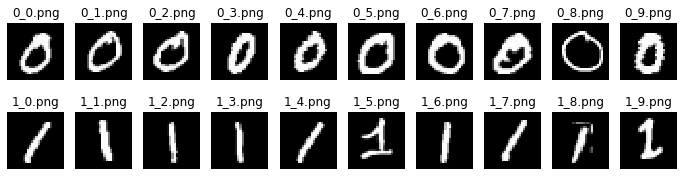

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
# ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
# zeros_im = skimage.io.concatenate_images(ic)
zeros_im = [skimage.io.imread(os.path.join(zeros_path, nm)) for nm in zeros_names]
zeros_im = np.asarray(zeros_im, dtype = 'uint8')

#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
# ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
# ones_im = skimage.io.concatenate_images(ic)
ones_im = [skimage.io.imread(os.path.join(ones_path, nm)) for nm in ones_names]
ones_im = np.asarray(ones_im, dtype = 'uint8')

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### Pre-Processing


##### As suggested, we implemented multiple steps of pre-processing to ensure we've obtained the best binary image possible that we wish to extract the features. First, we threshold the images with an arbitrary value (50 in this case). Then, we removed small objects that are not connected to the numbers via remove_small_objects library. After that, it made sense to dilate the images so we can better detect the contours. The resulting images are shown in the following cell.

In [24]:
kernel = np.ones((2,2),np.uint8)
ones_dilated = np.zeros(ones_im.shape)
zeros_dilated = np.zeros(zeros_im.shape)
ones_gradient = np.zeros(ones_im.shape)
zeros_gradient = np.zeros(ones_im.shape)

for i in np.arange(ones_im.shape[0]):
    _, ones_dilated[i, :, :] = cv2.threshold(ones_im[i,:,:],50,255,cv2.THRESH_BINARY)
    _, zeros_dilated[i, :, :] = cv2.threshold(zeros_im[i,:,:],50,255,cv2.THRESH_BINARY)
    ones_dilated[i, :, :] = morphology.remove_small_objects(ones_dilated[i, :, :].astype(bool), min_size=40)
    zeros_dilated[i, :, :] = morphology.remove_small_objects(zeros_dilated[i, :, :].astype(bool), min_size=40)
#     ones_dilated[i, :, :] = cv2.dilate(ones_dilated[i, :, :].astype(np.uint8),kernel,iterations = 1)
#     zeros_dilated[i, :, :] = cv2.dilate(zeros_dilated[i, :, :].astype(np.uint8),kernel,iterations = 1)
    ones_gradient[i,:,:] = cv2.morphologyEx(ones_dilated[i,:,:], cv2.MORPH_GRADIENT, kernel)
    zeros_gradient[i,:,:] = cv2.morphologyEx(zeros_dilated[i,:,:], cv2.MORPH_GRADIENT, kernel)

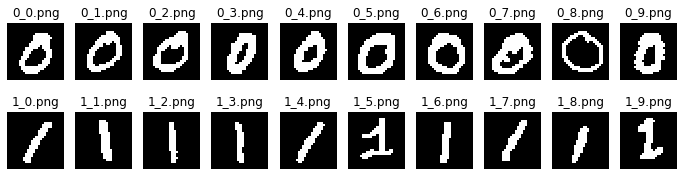

In [25]:
fig, axes = plt.subplots(2, len(ones_dilated), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_dilated, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_dilated, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

##### For the next step, we compute the gradient of the images to find the contours of numbers for each image. This simplifies the procedure of finding the pixels corresponding to numbers. Gradient images are observalble in the following. 

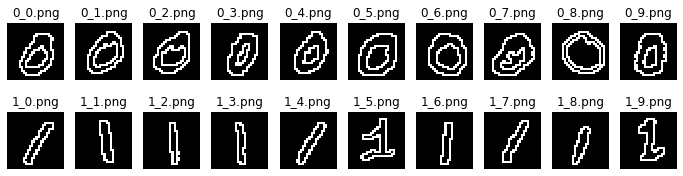

In [26]:
fig, axes = plt.subplots(2, len(ones_dilated), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_gradient, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_gradient, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

In [27]:
ones_contours = np.zeros(ones_im.shape)
zeros_contours = np.zeros(zeros_im.shape)
cnt_x_zeros = []
cnt_y_zeros = []
cnt_x_ones = []
cnt_y_ones = []


for i in np.arange(ones_im.shape[0]):
    contours = cv2.findContours(ones_gradient[i,:,:].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]
#     print(contours[0][:,0,:][:,0])
#     print('****')
#     print(contours[0][:,0,:][:,1])
    cnt_x_ones.append(contours[0][:,0,:][:,1])
    cnt_y_ones.append(contours[0][:,0,:][:,0])
    
    image = cv2.drawContours(ones_gradient[i,:,:].copy(), contours[0], -1, 128, 1)
    _,ones_contours[i,:,:] = cv2.threshold(image,50,255,cv2.THRESH_BINARY)
    
    contours = cv2.findContours(zeros_gradient[i,:,:].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]
    cnt_x_zeros.append(contours[0][:,0,:][:,1])
    cnt_y_zeros.append(contours[0][:,0,:][:,0])
    
    image = cv2.drawContours(zeros_gradient[i,:,:].copy(), contours[0], -1, 128, 1)
    _,zeros_contours[i,:,:] = cv2.threshold(image,50,255,cv2.THRESH_BINARY)

##### In the above cell, we are extracting a couple of useful information. First, the x and y coordinates of the pixels corresponding to contours are extracted (due to obvious reasons). Second handy information would be the images with only the biggest contours which means for the case of zeros, we are discarding the inner contour. The mentioned images are given in the next cell. 

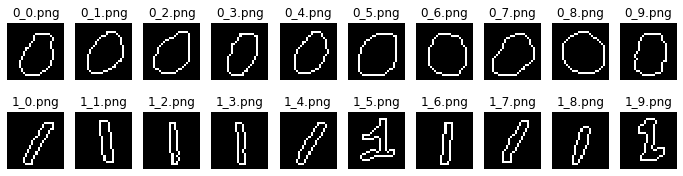

In [28]:
fig, axes = plt.subplots(2, len(ones_dilated), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_contours, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_contours, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

##### The below function applies all the steps described so far. Since this function will be used on multiple occasions in the future, we tried to output all the relevant information for various feature extractions. contour_list is the list of the pixels for each image that specifies the contour. cnt_x and cnt_y are (x,y) coordinates which are especially useful for Fourier descriptors. Finally, images_contours are images with only the outer contour binary values (same as above images).

In [29]:
def pre_processing_im(images):
    '''
    This function encapsulates all pre-processing steps
    This will be useful for later
    '''
    kernel = np.ones((2,2),np.uint8)
    images_dilated = np.zeros(images.shape)
    images_gradient = np.zeros(images.shape)
    images_contours = np.zeros(images.shape)
    raw = np.zeros((images.shape[1],images.shape[2]))
    cnt_x = []
    cnt_y = []
    contour_list = []
    
    for i in np.arange(images.shape[0]):
        _, images_dilated[i, :, :] = cv2.threshold(images[i,:,:],50,255,cv2.THRESH_BINARY)
        images_dilated[i, :, :] = morphology.remove_small_objects(images_dilated[i, :, :].astype(bool), min_size=40)
#         images_dilated[i, :, :] = cv2.dilate(images_dilated[i, :, :].astype(np.uint8),kernel,iterations = 1)
        images_gradient[i,:,:] = cv2.morphologyEx(images_dilated[i,:,:], cv2.MORPH_GRADIENT, kernel)
        contours = cv2.findContours(images_gradient[i,:,:].astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[1]
        images_contours[i,:,:] = cv2.drawContours(raw.copy(), contours[0], -1, 128, 1)
        contour_list.append(contours[0])
        cnt_x.append(contours[0][:,0,:][:,1])
        cnt_y.append(contours[0][:,0,:][:,0])
        
    return contour_list, cnt_x, cnt_y, images_contours
        


### 1.2 Fourier descriptors
Add your implementation and discussion

First, we try the descriptors without forcing them to be invariant to translation and scaling and use only the first two descriptors (we can show 2D plots so we have to compute the absolute value anyway which enforces rotation invariancy). Then we plot the results to check the inter/intra-class variation. As expected, we have two outliers corresponding to image 1-5 and 1-9 for ones. Although the clusters are fairly separate, the inter-class variation is not small compared to the intra-class variation which is not desired. We try different invariant descriptors techniques in turn to check how many issues can be resolved with this tool. 

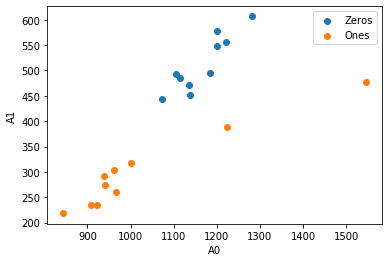

In [30]:
fft_zeros = []
fft_ones = []

for i in np.arange(len(ones_im)):
    a = np.absolute(np.fft.fft(cnt_x_zeros[i] + cnt_y_zeros[i]*1j)) #implements x+jy for fourier transform
    a = a[0:2] #considering the first descriptor
    fft_zeros.append(a)
    a = np.absolute(np.fft.fft(cnt_x_ones[i] + cnt_y_ones[i]*1j))
    a = a[0:2]
    fft_ones.append(a)
    
    
fft_zeros = np.asarray(fft_zeros, dtype='float')
fft_ones = np.asarray(fft_ones, dtype='float')

fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zeros')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'Ones')
plt.xlabel('A0')
plt.ylabel('A1')
ax.legend()

##### First, we discard the first term to be translation-invariant and check the result again. It seems that we managed to get 1-6 image closer to the other one images which mean the problem of that image was mostly concerned with the translation. However, the problem of separation between two classes is still present.

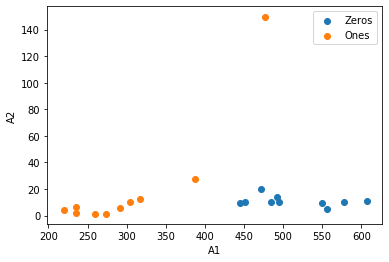

In [31]:
fft_zeros = []
fft_ones = []

for i in np.arange(len(ones_im)):
    a = np.absolute(np.fft.fft(cnt_x_zeros[i] + cnt_y_zeros[i]*1j)) #implements x+jy for fourier transform
    a = a[1:3] #considering the first descriptor
    fft_zeros.append(a)
    a = np.absolute(np.fft.fft(cnt_x_ones[i] + cnt_y_ones[i]*1j))
    a = a[1:3]
    fft_ones.append(a)
    
    
fft_zeros = np.asarray(fft_zeros, dtype='float')
fft_ones = np.asarray(fft_ones, dtype='float')

fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zeros')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'Ones')
plt.xlabel('A1')
plt.ylabel('A2')
ax.legend()

Finally, we try to make the approach robust to scaling. For that, we divide A1 and A2 by A0. Although the final plot seems to be improved in terms of inter versus intraclass variation, the problem of the 1-9 image outlier remains an issue for this approach. Moreover, it seems A2 is playing a more important role in discriminating the classes whereas in the former case we couldn't see this contribution. It is important to mention that the dataset does not contain a sufficient number of instances.

In [32]:
fft_zeros = []
fft_ones = []

for i in np.arange(len(ones_im)):
    a = np.absolute(np.fft.fft(cnt_x_zeros[i] + cnt_y_zeros[i]*1j))
    a = a/a[0]
    a = a[1:3]
    fft_zeros.append(a)
    a = np.absolute(np.fft.fft(cnt_x_ones[i] + cnt_y_ones[i]*1j))
    a = a/a[0]
    a = a[1:3]
    fft_ones.append(a)
    
    
fft_zeros = np.asarray(fft_zeros, dtype='float')
fft_ones = np.asarray(fft_ones, dtype='float')

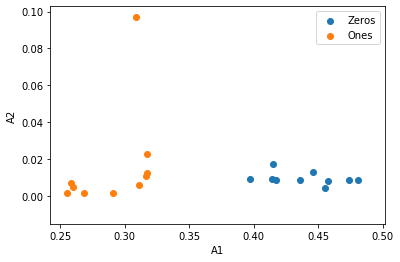

In [33]:
fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zeros')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'Ones')
plt.xlabel('A1')
plt.ylabel('A2')
ax.legend()

We implemented the Fourier descriptor function for future robustness validations.

In [34]:
def fourier_descriptors(contour_x, contour_y):
    fft_img = []
    for i in np.arange(len(contour_x)):
        a = np.absolute(np.fft.fft(contour_x[i] + contour_y[i]*1j))[0:3]
        a = a/a[0]
        a = a[1:3]
        fft_img.append(a)
        
    fft_img = np.asarray(fft_img, dtype='float')
    return fft_img

### Rotation
For rotation, we generated many samples on purpose to check the reliability of the approach. In the following, we consider the original data, and in turn, 30, 120, and 180 degrees rotated versions of them (arbitrary choices). The resulting plot is rather promising which means that if the dataset contained more data, the robustness of the approach would be better underlined.

In [35]:
rotated_ones = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in ones_im]
rotated_zeros = [transform.rotate(i, 90, resize=False, preserve_range=True).astype('uint8') for i in zeros_im]

rotated_ones = np.concatenate((rotated_ones, [transform.rotate(i, 30, resize=False, preserve_range=True).astype('uint8') for i in ones_im]), axis=0)
rotated_ones = np.concatenate((rotated_ones, [transform.rotate(i, 120, resize=False, preserve_range=True).astype('uint8') for i in ones_im]), axis=0)
rotated_ones = np.concatenate((rotated_ones, [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in ones_im]), axis=0)

rotated_zeros = np.concatenate((rotated_zeros, [transform.rotate(i, 120, resize=False, preserve_range=True).astype('uint8') for i in zeros_im]), axis=0)
rotated_zeros = np.concatenate((rotated_zeros, [transform.rotate(i, 120, resize=False, preserve_range=True).astype('uint8') for i in zeros_im]), axis=0)
rotated_zeros = np.concatenate((rotated_zeros, [transform.rotate(i, 180, resize=False, preserve_range=True).astype('uint8') for i in zeros_im]), axis=0)

_, cnt_x_ones, cnt_y_ones,_ = pre_processing_im(rotated_ones)
_, cnt_x_zeros, cnt_y_zeros,_ = pre_processing_im(rotated_zeros)
fft_ones = fourier_descriptors(cnt_x_ones, cnt_y_ones)
fft_zeros = fourier_descriptors(cnt_x_zeros, cnt_y_zeros)

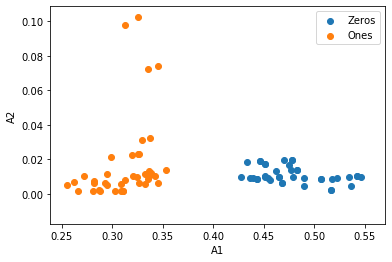

In [36]:
fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zeros')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'Ones')
plt.xlabel('A1')
plt.ylabel('A2')
ax.legend()

### Translation
The approach is evidently invariant to translation as this result is identical to the one without translation. We translated the images with the function warpAffine (with arbitrary values of translation delta_x = 1 and delta_y = -2).

In [37]:
M = np.array([[1,0,1],[0,1,-2]],dtype='float')
_,row, col = ones_im.shape
tr_ones = np.asarray([cv2.warpAffine(img,M,(row,col)).astype('uint8') for img in ones_im], dtype='uint8')
tr_zeros = np.asarray([cv2.warpAffine(img,M,(row,col)).astype('uint8') for img in zeros_im], dtype='uint8')

_, cnt_x_ones, cnt_y_ones, _ = pre_processing_im(tr_ones)
_, cnt_x_zeros, cnt_y_zeros, _ = pre_processing_im(tr_zeros)
fft_ones = fourier_descriptors(cnt_x_ones, cnt_y_ones)
fft_zeros = fourier_descriptors(cnt_x_zeros, cnt_y_zeros)

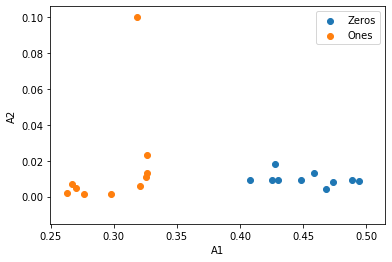

In [38]:
fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zeros')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'Ones')
plt.xlabel('A1')
plt.ylabel('A2')
ax.legend()

### Scaling

Finally, we scaled the images with resize function and concluded that this method is also invariant to scaling.

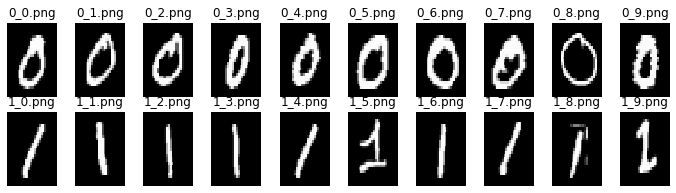

In [39]:
scaled_ones = np.asarray([cv2.resize(img, None, fx=2, fy=3, interpolation = cv2.INTER_AREA).astype('uint8') for img in ones_im], dtype='uint8')
scaled_zeros = np.asarray([cv2.resize(img, None, fx=2, fy=3, interpolation = cv2.INTER_AREA).astype('uint8') for img in zeros_im], dtype='uint8')

fig, axes = plt.subplots(2, len(ones_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], scaled_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], scaled_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
    
_, cnt_x_ones, cnt_y_ones, _ = pre_processing_im(scaled_ones)
_, cnt_x_zeros, cnt_y_zeros, _ = pre_processing_im(scaled_zeros)
fft_ones = fourier_descriptors(cnt_x_ones, cnt_y_ones)
fft_zeros = fourier_descriptors(cnt_x_zeros, cnt_y_zeros)

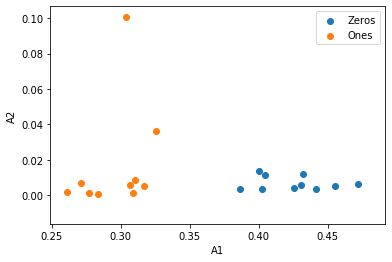

In [40]:
fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zeros')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'Ones')
plt.xlabel('A1')
plt.ylabel('A2')
ax.legend()

### 1.3 Additional method(s)
We tried to include as many methods as possible to achieve an appropriate intuition regarding the methods described in the class. We start this section with the Similarity Measure of images with the aid of their distance map.

## Similarity Measure of images

For similarity measure, we first define the function dist_map which takes a binary contour as the input and returns the distance map as the output. We provide the output of the function for the second one image which suggests that the function is performing expected calculations. We used an alteration of the Euclidian distance that was proposed in the lecture. Then, we define a image distance calculation function that outputs the RMS difference of the second image with respect to first one according to the given formula in lectures.

In [41]:
def dist_map(img):
    mask = img > 100
    v = np.full((img.shape), np.inf)
    v[mask] = 0
    row, col = img.shape
    
    for i in range(1,row-1):
        for j in range(1,col-1):
            v[i,j] = min(v[i-1,j-1]+4,v[i-1,j]+3,v[i-1,j+1]+4,v[i,j-1]+3,v[i,j])
            
    for i in range(row-2,0,-1):
        for j in range(col-2,0,-1):
            v[i,j] = min(v[i,j+1]+3,v[i+1,j-1]+4,v[i+1,j]+3,v[i+1,j+1]+4,v[i,j])
            
    return v

In [42]:
def calc_dist(img_map,comp_img):
    mask = (comp_img>100)
    values = img_map[mask]
    distance = (np.sum(values)**2)/len(values)
    distance = np.sqrt(distance)
    
    return distance

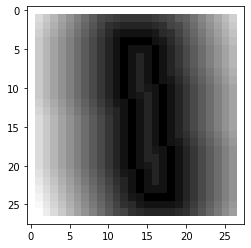

In [43]:
_, _, _, ones_cnts = pre_processing_im(ones_im)
_, _, _, zeros_cnts = pre_processing_im(zeros_im)

dist_one = dist_map(ones_cnts[1])
dist_zero = dist_map(zeros_cnts[1])

plt.imshow(dist_one, cmap='gray')

ones_dist_to_one = np.asarray([calc_dist(dist_one, img) for img in ones_cnts], dtype='float')
zeros_dist_to_one = np.asarray([calc_dist(dist_one, img) for img in zeros_cnts], dtype='float')

ones_dist_to_zero = np.asarray([calc_dist(dist_zero, img) for img in ones_cnts], dtype='float')
zeros_dist_to_zero = np.asarray([calc_dist(dist_zero, img) for img in zeros_cnts], dtype='float')

To bring insight into the proposed method, we plot the distance of all 20 images from a reference zero image and show it as the horizontal axis. On the vertical axis, we repeat the same calculation and this time we measure the distance to a reference one image. Ideally, all the one images should cluster in the bottom right corner and the zero images should be gathered in the top left of the plot. For the reasons that this case didn't happen, we can mention that we didn't apply the optimized transformation between images which means, translation, scaling and, rotation is causing this behavior. We try to address rotation and translation in the moments method.

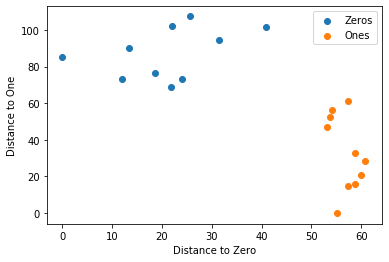

In [44]:
fig, ax = plt.subplots()
ax.scatter(zeros_dist_to_zero,zeros_dist_to_one, label = 'Zeros')
ax.scatter(ones_dist_to_zero,ones_dist_to_one, label = 'Ones')
plt.xlabel('Distance to Zero')
plt.ylabel('Distance to One')
ax.legend()

## Simple Region-Based descriptors

We try simple region-based descriptors to check whether they can be applied to this dataset or not. First, we try compacity. We expect that this value would be smaller for zeros due to their resemblance to circles. The following plot suggests that this method is relatively appropriate for this dataset as we can observe a clear separation between two classes and the fact that the variation along the y-axis is small for zeros and acceptable for ones would be a good sign.

In [45]:
ones_cnts, _, _, _ = pre_processing_im(ones_im)
zeros_cnts, _, _, _  = pre_processing_im(zeros_im)

area_ones = np.asarray([cv2.contourArea(img) for img in ones_cnts], dtype='float')
area_zeros = np.asarray([cv2.contourArea(img) for img in zeros_cnts], dtype='float')

perimeter_ones = np.asarray([cv2.arcLength(img,True) for img in ones_cnts], dtype='float')
perimeter_zeros = np.asarray([cv2.arcLength(img,True) for img in zeros_cnts], dtype='float')

compacity_ones = (perimeter_ones**2)/area_ones
compacity_zeros = (perimeter_zeros**2)/area_zeros

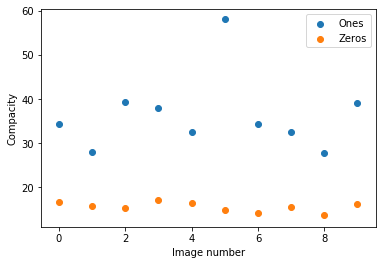

In [46]:
fig, ax = plt.subplots()
x=np.arange(len(ones_im))
ax.scatter(x, compacity_ones, label = 'Ones')
ax.scatter(x, compacity_zeros, label = 'Zeros')
plt.xlabel('Image number')
plt.ylabel('Compacity')
ax.legend()

#### Rectangularity
For this measure, we try the function cv2.minAreaRect since the definition implies that in order to have maximum value for the division, we should have the minimum bounding rectangle for the contour. One can observe the plot for image 1-0. The resulting plot suggests that this method is not a good descriptor for this dataset. However, we combine rectangularity and compacity to check how the combination of both serves the purpose.

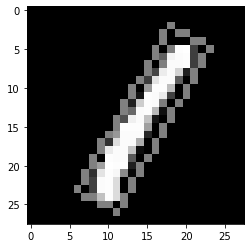

In [47]:
rect_ones = np.asarray([cv2.minAreaRect(img)[1][0]*cv2.minAreaRect(img)[1][1] for img in ones_cnts], dtype='float')
rect_zeros = np.asarray([cv2.minAreaRect(img)[1][0]*cv2.minAreaRect(img)[1][1] for img in zeros_cnts], dtype='float')

rect_ones = area_ones/rect_ones
rect_zeros = area_zeros/rect_zeros

rect = cv2.minAreaRect(ones_cnts[0])
box = cv2.boxPoints(rect)
box = np.int0(box)
im = cv2.drawContours(ones_im[0].copy(),[box],0,128,0)
plt.imshow(im,cmap='gray')

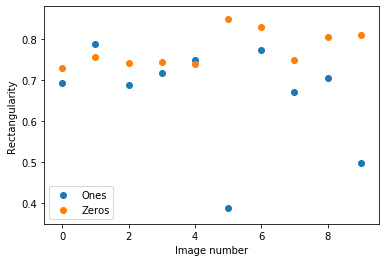

In [48]:
fig, ax = plt.subplots()
x=np.arange(len(ones_im))
ax.scatter(x, rect_ones, label = 'Ones')
ax.scatter(x, rect_zeros, label = 'Zeros')
plt.xlabel('Image number')
plt.ylabel('Rectangularity')
ax.legend()

Considering that these methods are invariant to rotation and translation (not scaling), the combination of them are showing an acceptable performance based on the following plot

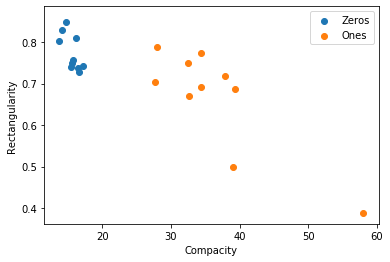

In [49]:
fig, ax = plt.subplots()
x=np.arange(len(ones_im))
ax.scatter(compacity_zeros, rect_zeros, label = 'Zeros')
ax.scatter(compacity_ones, rect_ones, label = 'Ones')
plt.xlabel('Compacity')
plt.ylabel('Rectangularity')
ax.legend()

To conclude simple region-based methods, we calculate elongation for all the images with the aid of the moments for each contour. We used the common formulas in the literature to define the following function. Then we plot the result as the vertical axis while keeping compacity as the x-axis. From the final plot, we can say that for zeros, the classification is done quite well whereas, for one images, the intra-class variation is not acceptable.

In [50]:
def elongation(image):
    _,thresh = cv2.threshold(image,100,255,cv2.THRESH_BINARY)
    moment = cv2.moments(thresh)
    x = moment['mu20'] + moment['mu02']
    y = 4 * moment['mu11']**2 + (moment['mu20'] - moment['mu02'])**2
    return (x + y**0.5) / (x - y**0.5)

In [51]:
elongation_ones = np.asarray([elongation(img) for img in ones_im], dtype='float')
elongation_zeros = np.asarray([elongation(img) for img in zeros_im], dtype='float')

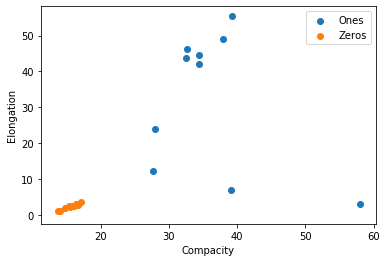

In [52]:
fig, ax = plt.subplots()
x=np.arange(len(ones_im))
ax.scatter(compacity_ones, elongation_ones, label = 'Ones')
ax.scatter(compacity_zeros, elongation_zeros, label = 'Zeros')
plt.xlabel('Compacity')
plt.ylabel('Elongation')
ax.legend()

## Moments

Another method that we implemented is the Moments approach. For that, cv2 provides the function cv2.matchShapes that is based on Hu Moments. Hu Moments are partially introduced in the lecture and they are supposed to be invariant to rotation, scaling, and translation. We follow a comparision framework similar to the one used in the distance map method. We compare the moments of all the images with a reference "1" and a reference "0" (3rd image for both). Again we expect that the clusters to be located at the bottom right and top left. However, this method was not as promising as we hoped and does not provide a good performance in terms of intra-class variation.

In [53]:
_, _, _, ones_cnts = pre_processing_im(ones_im)
_, _, _, zeros_cnts  = pre_processing_im(zeros_im)
base_one = ones_cnts[2]
base_zero = zeros_cnts[2]

dist_ones_to_one = np.asarray([cv2.matchShapes(base_one,img,cv2.CONTOURS_MATCH_I2,0) for img in ones_cnts], dtype='float')
dist_zeros_to_one = np.asarray([cv2.matchShapes(base_one,img,cv2.CONTOURS_MATCH_I2,0) for img in zeros_cnts], dtype='float')

dist_ones_to_zero = np.asarray([cv2.matchShapes(base_zero,img,cv2.CONTOURS_MATCH_I2,0) for img in ones_cnts], dtype='float')
dist_zeros_to_zero = np.asarray([cv2.matchShapes(base_zero,img,cv2.CONTOURS_MATCH_I2,0) for img in zeros_cnts], dtype='float')

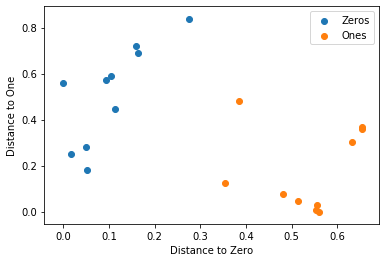

In [54]:
fig, ax = plt.subplots()
ax.scatter(dist_zeros_to_zero,dist_zeros_to_one, label = 'Zeros')
ax.scatter(dist_ones_to_zero,dist_ones_to_one, label = 'Ones')
plt.xlabel('Distance to Zero')
plt.ylabel('Distance to One')
ax.legend()

Finally, we combine the first additional method, i.e., similarity measure with the moment's method. We attempt to apply the best transformation on the images to be able to optimally analyze them in the sense of distance between each image. First, we calculate the center of each contour with their moment and then we calculate the angle of the contour by the aid of axes of inertia. We move this center to [13 13] for all the contours and then rotate each contour to cancel the rotation contribution. We apply the mentioned steps in the transform_img function and we have plotted the output of this function for each image.

In [55]:
ones_cnts, _, _, _ = pre_processing_im(ones_im)
Zeros_cnts, _, _, _ = pre_processing_im(zeros_im)
M = cv2.moments(ones_cnts[0])
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
print(cx,cy)
alpha = 0.5*np.arctan((2*M['m11'])/(M['m20'] - M['m02']))
alpha = alpha*180/np.pi
print(alpha)

14 14
-43.60186432359163


In [56]:
alpha=0.5*np.arctan(2*M['m11']/(M['m20'] - M['m02']))*180/np.pi
print(alpha)
rect = cv2.minAreaRect(ones_cnts[0])
rect[2]

-43.60186432359163


-59.534454345703125

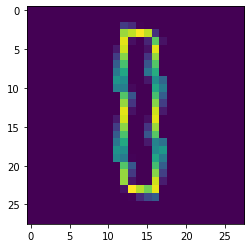

In [57]:
def transform_img(img_cnt, img):
    alpha = cv2.minAreaRect(img_cnt)[2]
    M = cv2.moments(img_cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    T = np.array([[1,0,13-cx],[0,1,13-cy]],dtype='float')
    row, col = img.shape
    res = cv2.warpAffine(img,T,(col,row)).astype('uint8')
    if alpha < -45:
        res = transform.rotate(res, 90+alpha, resize=False, preserve_range=True).astype('uint8')
    else:
        res = transform.rotate(res, alpha, resize=False, preserve_range=True).astype('uint8')
    
    return res
    
ones_cnts, _, _, ones_cnt_im = pre_processing_im(ones_im)
im = transform_img(ones_cnts[1],ones_cnt_im[1])
plt.imshow(im)

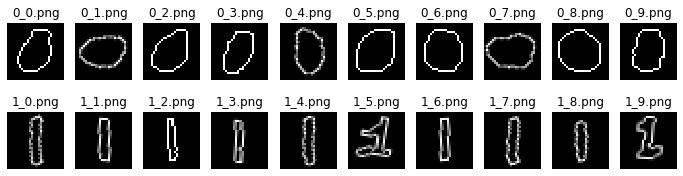

In [58]:
ones_cnts, _, _, ones_cnts_im = pre_processing_im(ones_im)
zeros_cnts, _, _, zeros_cnts_im = pre_processing_im(zeros_im)

tr_ones = np.asarray([transform_img(img_cnt, img) for img_cnt, img in zip(ones_cnts,ones_cnts_im)], dtype='float')
tr_zeros = np.asarray([transform_img(img_cnt, img) for img_cnt, img in zip(zeros_cnts,zeros_cnts_im)], dtype='float')
dist_one = dist_map(tr_ones[2])
dist_zero = dist_map(tr_zeros[6])

fig, axes = plt.subplots(2, len(ones_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], tr_zeros, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], tr_ones, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

ones_dist_to_one = np.asarray([calc_dist(dist_one, img) for img in tr_ones], dtype='float')
zeros_dist_to_one = np.asarray([calc_dist(dist_one, img) for img in tr_zeros], dtype='float')

ones_dist_to_zero = np.asarray([calc_dist(dist_zero, img) for img in tr_ones], dtype='float')
zeros_dist_to_zero = np.asarray([calc_dist(dist_zero, img) for img in tr_zeros], dtype='float')

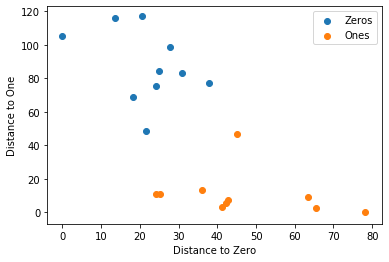

In [59]:
fig, ax = plt.subplots()
ax.scatter(zeros_dist_to_zero,zeros_dist_to_one, label = 'Zeros')
ax.scatter(ones_dist_to_zero,ones_dist_to_one, label = 'Ones')
plt.xlabel('Distance to Zero')
plt.ylabel('Distance to One')
ax.legend()

It seems that we managed to provide a better comparison for '1' images in the sense that all of them are close to the reference '1' (intra-class variation has been improved). However, it seems that the distance of two classes, i.e, inter-class variation has been decreased at the same time which is not desired. Addressing the scaling problem could address this issue to some extent.

#### Moments (second approach)
Still using moments, we also tried another approach, simply using two moments as features in the feature vector. From cv2, we used the functions cv2.moments and cv2.HuMoments. We try three different kind of moments:
- centered moments: defined on slide 40 of lecture 4, invariant only in translation (we chose mu20 and mu02 which basicaly corresponds to the variance of the object along the x and y axis)
- centered and invariant in rotation moments: defined on slide 41 of lecture 4, invariant in translation and rotation (we simply pick the first two moments)
- hu moments: defined on slide 42 of lecture 4, invariant in translation, rotation and scaling (again, simply the first two)

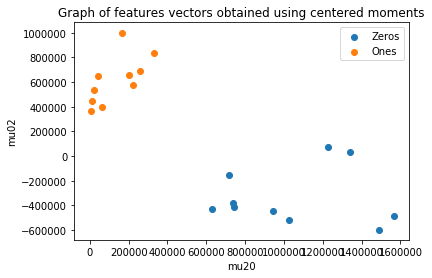

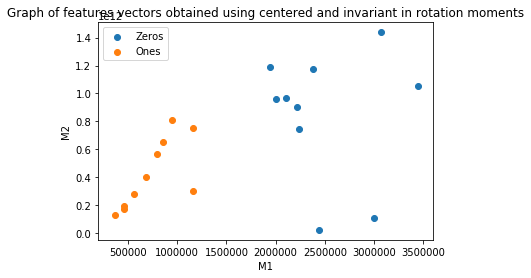

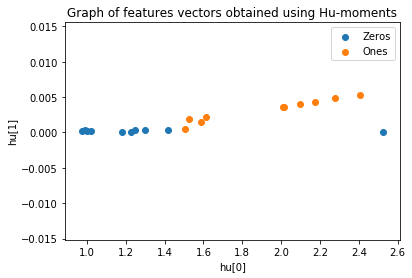

In [60]:
#get binary images with simple thresholding
zeros_bin = zeros_im.copy()
zeros_bin[zeros_bin[:,:,:] >= 50] = 255
zeros_bin[zeros_bin[:,:,:] < 50] = 0
ones_bin = ones_im.copy()
ones_bin[ones_bin[:,:,:] >= 50] = 255
ones_bin[ones_bin[:,:,:] < 50] = 0

# quick preprocessing with closing to remove some noise
kernel = np.ones((2,2),np.uint8)
for i in range(10):
    ones_bin[i,:,:] = cv2.morphologyEx(ones_bin[i,:,:], cv2.MORPH_OPEN, kernel)
    zeros_bin[i,:,:] = cv2.morphologyEx(zeros_bin[i,:,:], cv2.MORPH_OPEN, kernel)

    
#intialize feature vectors for three kinds of moments
#centered moments
moments_zeros = np.zeros((10,2))
moments_ones = np.zeros((10,2))

#centered and invariant in rotation moments
moments_rot_invariant_zeros = np.zeros((10,2))
moments_rot_invariant_ones = np.zeros((10,2))

#hu moments
humoments_zeros = np.zeros((10,2))
humoments_ones = np.zeros((10,2))


#compute them using cv2
for i in range(10):
    mom = cv2.moments(zeros_bin[i,:,:])
    moments_rot_invariant_zeros[i,0] = mom['mu20'] + mom['mu02']
    moments_rot_invariant_zeros[i,1] = (mom['mu20'] - mom['mu02'])**2 + 4 * mom['mu11']**2
    moments_zeros[i,0] = mom['mu20']
    moments_zeros[i,1] = mom['mu11']
    humoments_zeros[i,:] = 1000*cv2.HuMoments(mom)[:2,:].squeeze()
    
    mom = cv2.moments(ones_bin[i,:,:])
    moments_rot_invariant_ones[i,0] = mom['mu20'] + mom['mu02']
    moments_rot_invariant_ones[i,1] = (mom['mu20'] - mom['mu02'])**2 + 4 * mom['mu11']**2
    moments_ones[i,0] = mom['mu20']
    moments_ones[i,1] = mom['mu02']
    humoments_ones[i,:] = 1000*cv2.HuMoments(mom)[:2,:].squeeze()
        
#plot    
fig, ax = plt.subplots()
ax.scatter(moments_zeros[:,0],moments_zeros[:,1], label = 'Zeros')
ax.scatter(moments_ones[:,0],moments_ones[:,1], label = 'Ones')
plt.xlabel('mu20')
plt.ylabel('mu02')
ax.legend()
ax.set_title('Graph of features vectors obtained using centered moments')
plt.show()

fig, ax = plt.subplots()
ax.scatter(moments_rot_invariant_zeros[:,0],moments_rot_invariant_zeros[:,1], label = 'Zeros')
ax.scatter(moments_rot_invariant_ones[:,0],moments_rot_invariant_ones[:,1], label = 'Ones')
plt.xlabel('M1')
plt.ylabel('M2')
ax.legend()
ax.set_title('Graph of features vectors obtained using centered and invariant in rotation moments')
plt.show()

fig, ax = plt.subplots()
ax.scatter(humoments_zeros[:,0],humoments_zeros[:,1], label = 'Zeros')
ax.scatter(humoments_ones[:,0],humoments_ones[:,1], label = 'Ones')
plt.xlabel('hu[0]')
plt.ylabel('hu[1]')
ax.legend()
ax.set_title('Graph of features vectors obtained using Hu-moments')
plt.show()


We can observe that two moments can be used as features to discriminate between the two classes. When using centered moments and invariant to rotation moments, we can observe that both classes are linearly separable, and the inter-class variance appears to be relatively high. In the hu-moments case, inter-class variation appears limited, and one zero-outlier causes the two classe to not be completely linearly separable, this last kind of moments is not really effective at discriminating between the two classes, in this particular case.

## PCA
We try to apply one last method to extract a feature vector from the images, Principal Component Analysis. It was not discussed in the lecture, but we felt like it could show good results on this specific problem. Simply put, it consists in projecting each image (seen as a 28*28=784 dimensions vector) on the two dimensions along which the variance of the whole dataset is maximized . This projection becomes our feature vector. 

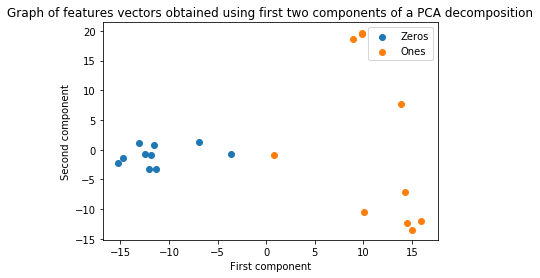

In [61]:
#normalize images and reshape them as vectors
ones_normalized = ones_im.astype('float')
zeros_normalized = zeros_im.astype('float')

ones_normalized -= np.expand_dims(ones_normalized.mean((1,2)),(1,2))
ones_normalized /= np.expand_dims(ones_normalized.std((1,2)),(1,2))
ones_normalized = ones_normalized.reshape((10,784))

zeros_normalized -= np.expand_dims(zeros_normalized.mean((1,2)),(1,2))
zeros_normalized /= np.expand_dims(zeros_normalized.std((1,2)),(1,2))
zeros_normalized = zeros_normalized.reshape((10,784))

#apply PCA
pca = PCA(n_components=2)
x=pca.fit_transform(np.concatenate((zeros_normalized, ones_normalized), axis=0))

#plot features
fig, ax = plt.subplots()
ax.scatter(x[0:10,0], x[0:10,1],  label="Zeros")
ax.scatter(x[10:,0], x[10:,1],  label="Ones")
ax.set_xlabel("First component")
ax.set_ylabel("Second component")
plt.legend(loc=0)
ax.set_title('Graph of features vectors obtained using first two components of a PCA decomposition')
plt.show()  


#function doing the same thing, to reuse in part 2
def extract_feature_with_PCA(im_set):
    dataset = np.zeros((len(im_set)*10, 784))
    for i in range(len(im_set)):
        tmp = im_set[i].astype('float')
        tmp -= np.expand_dims(tmp.mean((1,2)),(1,2))
        tmp /= np.expand_dims(tmp.std((1,2)),(1,2))
        dataset[i*10:i*10+10,:] = tmp.reshape((10,784))
    #apply PCA
    pca = PCA(n_components=2)
    x=pca.fit_transform(dataset)
    #return projection
    return x

We can observe that using this method, we are also able to separate both class into two clusters. Appart from image 1_5 ("one" dot in the middle) once again, the resulting inter-class variance along the first component appears quite significant compared to the intra-class variance.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

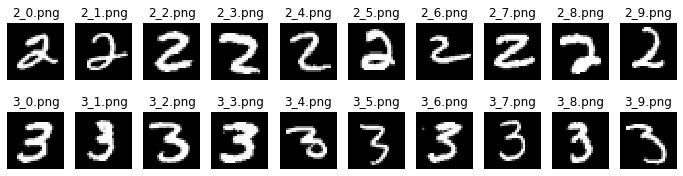

In [62]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
twos_im = [skimage.io.imread(os.path.join(twos_path, nm)) for nm in twos_names]
twos_im = np.asarray(twos_im, dtype = 'uint8')

#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
threes_im = [skimage.io.imread(os.path.join(threes_path, nm)) for nm in threes_names]
threes_im = np.asarray(threes_im, dtype = 'uint8')

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

We apply the same procedure as we applied for '1' and '0' images for '2's and '3's. Then, we compute the second and third Fourier descriptors and normalize them all. Finally, we plot the result from the combination of each FFT descriptors. As the plot suggests, there is no clear way to discriminate between these 4 classes with a 2-D feature and we certainly need more dimensions.

In [63]:
# deriving the coordinates for all images
_, cnt_x_ones, cnt_y_ones,_ = pre_processing_im(zeros_im)
_, cnt_x_zeros, cnt_y_zeros,_ = pre_processing_im(ones_im)
_, cnt_x_twos, cnt_y_twos,_ = pre_processing_im(twos_im)
_, cnt_x_threes, cnt_y_threes,_ = pre_processing_im(threes_im)

# calculating Fourier descriptors
fft_zeros = fourier_descriptors(cnt_x_zeros, cnt_y_zeros)
fft_ones = fourier_descriptors(cnt_x_ones, cnt_y_ones)
fft_twos = fourier_descriptors(cnt_x_twos, cnt_y_twos)
fft_threes = fourier_descriptors(cnt_x_threes, cnt_y_threes)

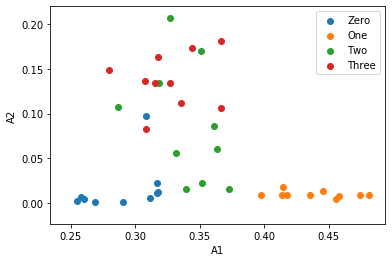

In [64]:
#plotting the results
fig, ax = plt.subplots()
ax.scatter(fft_zeros[:,0],fft_zeros[:,1], label = 'Zero')
ax.scatter(fft_ones[:,0],fft_ones[:,1], label = 'One')
ax.scatter(fft_twos[:,0],fft_twos[:,1], label = 'Two')
ax.scatter(fft_threes[:,0],fft_threes[:,1], label = 'Three')
plt.xlabel('A1')
plt.ylabel('A2')
ax.legend()

### 2.2 Additional method(s) and conclusion
In this section we apply couple of the methods used for the first part here. The reason is that some of the methods only can be plotted for two classes and not more. Nevertheless, it's highly unlikely that any of them could discriminate all the classes properly. For the methods that only work with two classes, we only use them for comparison of '2' and '3' images.

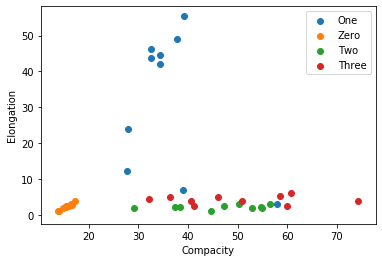

In [65]:
elongation_twos = np.asarray([elongation(img) for img in twos_im], dtype='float')
elongation_threes = np.asarray([elongation(img) for img in threes_im], dtype='float')

twos_cnts, _, _,_ = pre_processing_im(twos_im)
threes_cnts, _, _,_ = pre_processing_im(threes_im)

area_twos = np.asarray([cv2.contourArea(img) for img in twos_cnts], dtype='float')
area_threes = np.asarray([cv2.contourArea(img) for img in threes_cnts], dtype='float')

perimeter_twos = np.asarray([cv2.arcLength(img,True) for img in twos_cnts], dtype='float')
perimeter_threes = np.asarray([cv2.arcLength(img,True) for img in threes_cnts], dtype='float')

compacity_twos = (perimeter_twos**2)/area_twos
compacity_threes = (perimeter_threes**2)/area_threes

fig, ax = plt.subplots()
x=np.arange(len(ones_im))
ax.scatter(compacity_ones, elongation_ones, label = 'One')
ax.scatter(compacity_zeros, elongation_zeros, label = 'Zero')
ax.scatter(compacity_twos, elongation_twos, label = 'Two')
ax.scatter(compacity_threes, elongation_threes, label = 'Three')
plt.xlabel('Compacity')
plt.ylabel('Elongation')
ax.legend()

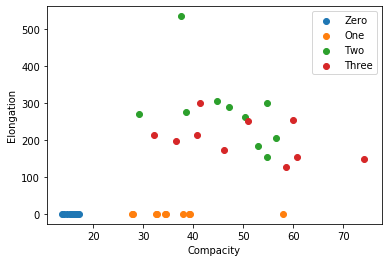

In [66]:
rect_twos = np.asarray([cv2.minAreaRect(img)[1][0]*cv2.minAreaRect(img)[1][1] for img in twos_cnts], dtype='float')
rect_threes = np.asarray([cv2.minAreaRect(img)[1][0]*cv2.minAreaRect(img)[1][1] for img in threes_cnts], dtype='float')

rect_twos = area_twos/rect_ones
rect_threes = area_threes/rect_zeros

fig, ax = plt.subplots()
x=np.arange(len(ones_im))
ax.scatter(compacity_zeros, rect_zeros, label = 'Zero')
ax.scatter(compacity_ones, rect_ones, label = 'One')
ax.scatter(compacity_twos, rect_twos, label = 'Two')
ax.scatter(compacity_threes, rect_threes, label = 'Three')
plt.xlabel('Compacity')
plt.ylabel('Elongation')
ax.legend()

As the Fourier descriptor method, both of the simple region-based methods failed to acheive a reasonable seperation for all classes. Now we move on to distance map approach for just '2' and '3' images.

#### Similarity Measure
By observing the result for similarity measure we realize that this method is not efficient in separating '2' and '3' images

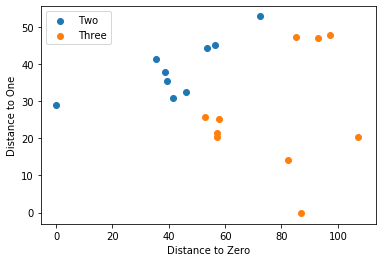

In [67]:
_, _, _, twos_cnts = pre_processing_im(twos_im)
_, _, _, threes_cnts = pre_processing_im(threes_im)

dist_two = dist_map(twos_cnts[0])
dist_three = dist_map(threes_cnts[0])

twos_dist_to_two = np.asarray([calc_dist(dist_two, img) for img in twos_cnts], dtype='float')
threes_dist_to_two = np.asarray([calc_dist(dist_one, img) for img in threes_cnts], dtype='float')

twos_dist_to_three = np.asarray([calc_dist(dist_three, img) for img in twos_cnts], dtype='float')
threes_dist_to_three = np.asarray([calc_dist(dist_three, img) for img in threes_cnts], dtype='float')

fig, ax = plt.subplots()
ax.scatter(twos_dist_to_two,twos_dist_to_three, label = 'Two')
ax.scatter(threes_dist_to_two,threes_dist_to_three, label = 'Three')
plt.xlabel('Distance to Zero')
plt.ylabel('Distance to One')
ax.legend()

#### Moments
As in part 1, we also try using feature vectors composed of moments, here we only try centered-moments which was the most effective in part 1.

In [68]:
def moment_img(images):    

    mu_20=[]
    mu_02=[]
    
    for im in images:
        M = cv2.moments(im);
        mu_20.append(M["mu20"])
        mu_02.append(M["mu02"])
        
    second_moment = (mu_02,mu_20)
    return np.asarray(second_moment, dtype='float')


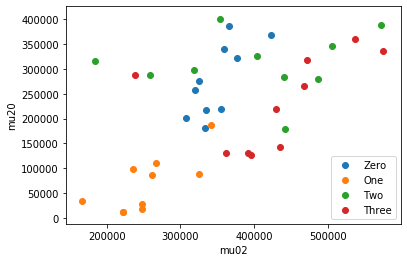

In [71]:
_, _, _, zeros_cnts = pre_processing_im(zeros_im)
_, _, _, ones_cnts = pre_processing_im(ones_im)
_, _, _, twos_cnts = pre_processing_im(twos_im)
_, _, _, threes_cnts = pre_processing_im(threes_im)

zero_moments = moment_img(zeros_cnts)
one_moments = moment_img(ones_cnts)
two_moments = moment_img(twos_cnts)
three_moments = moment_img(threes_cnts)

fig, ax = plt.subplots()
ax.scatter(zero_moments[0],zero_moments[1], label='Zero')
ax.scatter(one_moments[0],one_moments[1], label='One')
ax.scatter(two_moments[0],two_moments[1], label='Two')
ax.scatter(three_moments[0],three_moments[1], label='Three')
plt.xlabel('mu02')
plt.ylabel('mu20')
ax.legend()

Similar to other methods, this one also fails to seperate all the classes.

#### PCA
We also tested the pca method used earlier on the new problem:

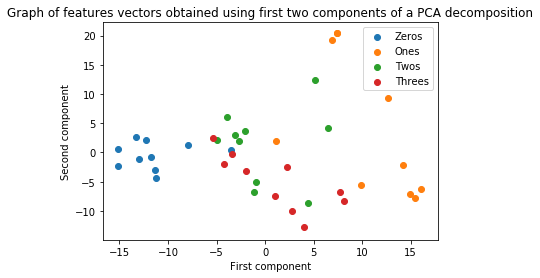

In [13]:
#pca
x = extract_feature_with_PCA((zeros_im, ones_im, twos_im, threes_im))

fig, ax = plt.subplots()
ax.scatter(x[0:10,0], x[0:10,1], label="Zeros")
ax.scatter(x[10:20,0], x[10:20,1],label="Ones")
ax.scatter(x[20:30,0], x[20:30,1], label="Twos")
ax.scatter(x[30:40,0], x[30:40,1], label="Threes")

ax.set_xlabel("First component")
ax.set_ylabel("Second component")
plt.legend(loc=0)
ax.set_title('Graph of features vectors obtained using first two components of a PCA decomposition')
plt.show()  

As with the previous methods, we are not able to cluster the four classes correctly using only two coponent of PCA decomposition.